In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
import os
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns

In [3]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'
def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE,file_name))

In [4]:
df_sales=read_database('2022-04-01T12_df_sales.csv')
df_sales['date']=pd.to_datetime(df_sales['date'])
df_users=read_database('experiment_users.csv')

df_sales - information about purchases, one row - one order. Attributes:
- sale_id - purchase identifier;
- date - date of purchase;
- count_pizza - number of pizzas in the order;
- count_drink - number of drinks in the order;
- price - price of the order;
- user_id - user identifier;

df_users - list of users of the experiment broken down into groups

In [5]:
df_users.head()

,user_id,pilot
0,0ffc65,0
1,b962b9,0
2,7ea63f,0
3,7f9a61,0
4,459e55,0


In [6]:
df_users['pilot'].value_counts()

0    11769
1    11564
Name: pilot, dtype: int64

In [7]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [8]:
# Calculate a metric
begin_daie=datetime(2022,3,23)
end_date=datetime(2022,3,30)
df_metrics=(
    df_sales[(df_sales['date']>=begin_daie)&(df_sales['date']<=end_date)].groupby('user_id')[['price']].sum().reset_index()
)

In [9]:
df_metrics.head()

,user_id,price
0,0000d4,720
1,0000de,660
2,0000e4,840
3,0001e2,2430
4,0001ff,720


In [10]:
df_users_metrics=pd.merge(df_users,df_metrics,how='left',on='user_id').fillna(0)
df_users_metrics.head()


,user_id,pilot,price
0,0ffc65,0,0.0
1,b962b9,0,840.0
2,7ea63f,0,0.0
3,7f9a61,0,0.0
4,459e55,0,0.0


In [11]:
data_control=df_users_metrics[df_users_metrics['pilot']==0]['price']
data_pilot=df_users_metrics[df_users_metrics['pilot']==1]['price']
stats.ttest_ind(data_control,data_pilot)

Ttest_indResult(statistic=-7.800743549967138, pvalue=6.411291718224787e-15)

**Conclusion:** 
- At the significance level of 0.05, the hypothesis of equality of mean is rejected
- The change is statistically significant

In [12]:
# Calculate a metric for a period
begin_daie=datetime(2022,3,16)
end_date=datetime(2022,3,23)
df_metrics=(
    df_sales[(df_sales['date']>=begin_daie)&(df_sales['date']<=end_date)].groupby('user_id')[['price']].sum().reset_index()
)
df_users_metrics=pd.merge(df_users,df_metrics,how='left',on='user_id').fillna(0)
data_control=df_users_metrics[df_users_metrics['pilot']==0]['price']
data_pilot=df_users_metrics[df_users_metrics['pilot']==1]['price']
stats.ttest_ind(data_control,data_pilot)

Ttest_indResult(statistic=-1.2837567415000515, pvalue=0.19923983306424942)

**Conclusion:** 
- At the significance level of 0.05, the hypothesis of equality of mean is accepted
- The change is not statistically significant

In [13]:
#Estimate the average time between purchases for customers with 2 or more purchases 

df_2=df_sales.groupby('user_id')[['date']].agg(['count','min','max'])
df_2.columns = [x[1] for x in df_2.columns] # fix column headings 
df_2=df_2[df_2['count']>=2]
df_2['delta']=(df_2['max']-df_2['min']).dt.total_seconds()
sum_delta=df_2['delta'].sum() # total time (in sec) between purchases
count_periods = df_2['count'].sum() - len(df_2) # total number periods between purchases
result=sum_delta/count_periods/3600/24

print("average time between purchases - ", int(round(result)), "days")





average time between purchases -  17 days


In [14]:
# Function to get p-value 

def get_ttest_pvalue(metrics_a_group,metrics_b_group):
   return print("pvalue =",(stats.ttest_ind(metrics_a_group,metrics_b_group).pvalue))

    

In [15]:
def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

In [16]:
# Test the function with example data
metrics_a_group = np.array([964, 1123, 962, 1213, 914, 906, 951, 1033, 987, 1082])
metrics_b_group = np.array([952, 1064, 1091, 1079, 1158, 921, 1161, 1064, 819, 1065])
pvalue = get_ttest_pvalue(metrics_a_group, metrics_b_group)


### MDE. Sample size

In [17]:
web_logs=read_database('2022-04-01T12_df_web_logs.csv')

In [18]:
web_logs.head()


,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


Web-logs - table with logs of site visits.

1. user_id - user ID;
2. page - what page of the site was opened. Page types:
    + m - page with menu;
    + b - page with cart and order confirmation;
    + p - page with order payment;
3. date - date of page opening;
4. load_time - page load time in milliseconds.

**The data is assumed to be independent**

min date- 2022-02-03 23:45:37 max_date- 2022-04-01 11:59:57
(1964507, 4)


<AxesSubplot:>

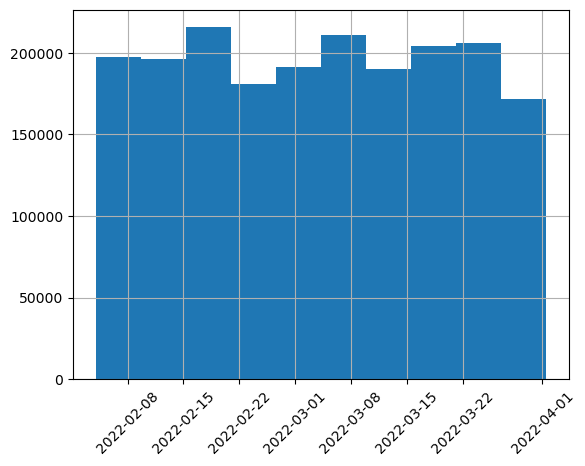

In [19]:
web_logs['date']=pd.to_datetime(web_logs['date'])
print('min date-',web_logs['date'].min(),'max_date-',web_logs['date'].max())
print(web_logs.shape)
web_logs['date'].hist(xrot=45)

In [20]:
#Suppose we want to run the test for one week.
web_logs_hist=web_logs[
    (web_logs['date']>=datetime(2022,3,22)) &
    (web_logs['date']<datetime(2022,3,29))
]
web_logs_hist.shape

(247163, 4)

In [21]:
# for an equel variance 
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, effect_size=1.01, alpha=0.05, beta=0.2): # if we want to calculete relative effect size
    epsilon = (effect_size - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

We want to be able to detect 1% effect in the page load time with a high probability.

In [22]:
# Experiment parameters

alpha=0.05 # significance level
beta=0.2 # power of the test
effect_size=1.01 # 1% effect 

mean=web_logs_hist['load_time'].mean()
std=web_logs_hist['load_time'].std()
print(mean,std)

74.09834562616594 111.56972405581025


In [23]:
sample_size=get_sample_size_abs(mean/100,std,alpha=alpha,beta=beta) 
print("Sample size for each group:", sample_size)


Sample size for each group: 355889


Since sample size for each group is 355889, the experiment requires 700 000 observations, while we have only 247 000. 
What effect can be detected with current amount of oservations? 

In [24]:
def get_minimal_determinable_effect (std,sample_size, alpha=0.05, beta=0.2):
    t_alpha=norm.ppf(1-alpha/2, loc=0,scale=1)
    t_beta=norm.ppf(1-beta, loc=0,scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

In [25]:
mde=get_minimal_determinable_effect(std,web_logs_hist.shape[0] //2,alpha=alpha,beta=beta)
print(f'mde = {np.round(mde, 3)}')
print(f'mde = {np.round(mde / mean * 100, 3)}%')

mde = 1.257
mde = 1.697%


with 247 000 observations we can detect 1.697% effect 

How many pages downloads do we need to detect 3% effect? 

In [26]:
alpha = 0.05
beta = 0.2
eff = 1.03
sample_size=get_sample_size_arb(mean,std,effect_size=eff,alpha=alpha,beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 39544


How many customers do we need in each group? 

In [27]:
ratio=web_logs_hist.groupby(['user_id'])['load_time'].count().mean()
print(ratio)

7.015298592188919


In [28]:
n_users=int(sample_size/ratio)+1
print(f'n_users = {n_users}')

n_users = 5637


Therefore, based on historical data, each group requires 6,000 users to be allocated to each group that will generate enough traffic that we are able to capture the 3% effect at a significance level of 0.05 and a power of 0

In [29]:


sales=read_database('2022-04-01T12_df_sales.csv')
sales['date']=pd.to_datetime(sales['date'])
sales_hist=sales[
    (sales['date']>=datetime(2022,2,21)) &
    (sales['date']<datetime(2022,2,28))
]
sales_hist.head() 


,sale_id,date,count_pizza,count_drink,price,user_id
63207,1063208,2022-02-21 10:02:02,4,1,3030,fcaa0f
63208,1063209,2022-02-21 10:04:43,3,1,2250,8d8445
63209,1063210,2022-02-21 10:05:40,1,0,780,e21af3
63210,1063211,2022-02-21 10:09:01,4,0,2880,e23104
63211,1063212,2022-02-21 10:11:20,2,1,1620,748932


In [30]:
begin_date = datetime(2022, 2, 21)
end_date = datetime(2022, 2, 28)
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .reset_index())
df_metrics.shape

(24840, 2)

In [31]:
sales_hist.shape

(25347, 6)

In [32]:
mean=sales_hist['price'].mean()
std=sales_hist['price'].std()
print(mean,std)

1209.9905314238372 783.1782330895605


In [33]:
mean=df_metrics['price'].mean()
std=df_metrics['price'].std()
print(mean,std)

1234.6871980676328 811.1803387604872


In [34]:
sample_size=get_sample_size_abs(20, std, alpha=alpha, beta=beta)
alpha = 0.05
beta = 0.1
eff = 20 # 20 usd effect 
print(f'sample_size = {round(sample_size,-1)}')

sample_size = 25820


In [35]:
mde=get_minimal_determinable_effect(std,df_metrics.shape[0]//2,alpha=alpha,beta=beta)
print(f'mde = {np.round(mde, 3)}')
print(f'mde = {np.round(mde / mean * 100, 3)}%')

mde = 33.367
mde = 2.702%


In [36]:
def estimate_sample_size(metrics, effect, alpha, beta):
    std = np.std(metrics['metric'].values)
    mean = np.mean(metrics['metric'].values)
    epsilon = effect / 100 * mean
    # ratio of the number of unique users to the number of observations
    coef = metrics['user_id'].nunique() / len(metrics)
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2) * coef
        )
    )
    return sample_size

### Experiment design test

In [37]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

web_logs = read_database('2022-04-01T12_df_web_logs.csv')

In [38]:
sales = read_database('2022-04-01T12_df_sales.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


2022-02-04 10:00:24
2022-04-01 11:59:51
(203847, 6)


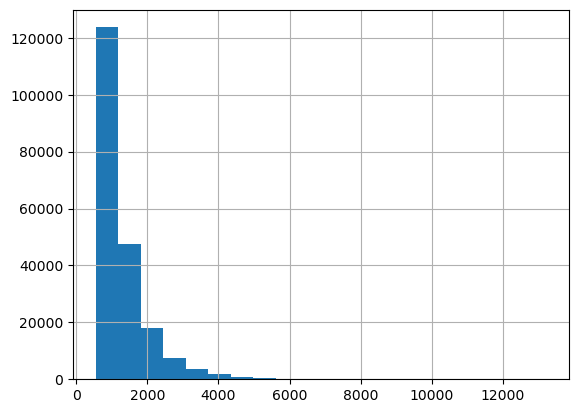

In [39]:
print(sales['date'].min())
print(sales['date'].max())
print(sales.shape)
sales['price'].hist(bins=20);

Let's assume that we want to run the test for 4 weeks.

For this purpose, we will choose an interval of one week on the historical interval and perform all calculations for this time interval. Note that today is April 1, so we have taken the week immediately before the start of the experiment.

In [40]:
sales_hist=sales[
    (sales['date']>=datetime(2022,3,1)) &
    (sales['date']<datetime(2022,3,29))
]
sales_hist.shape

(101951, 6)

In [41]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

To check the correctness of the experiment design, we must simulate this experiment on historical data many times. First, let us check whether the probability of the 1st type of error is controlled. For this purpose, the objects in our sample will be **checks**. That is, we divide all people into 2 groups, collect all checks independently, and run a t-test.

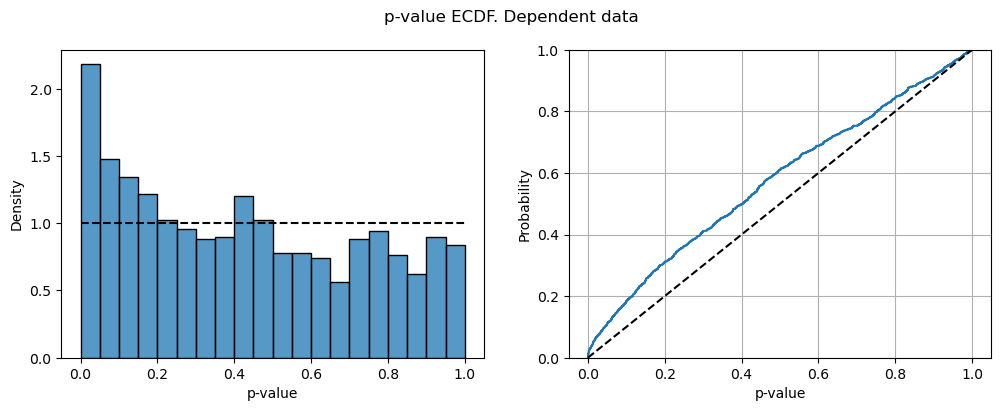

In [42]:
p_values=[]
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=sales_hist[sales_hist['user_id'].isin(group_a)]['price']
    sales_b=sales_hist[sales_hist['user_id'].isin(group_b)]['price']
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

In [43]:
print((np.array(p_values) < 0.05).mean(),'real probability of false positive result (I type error) with significance level 0.05')

0.109 real probability of false positive result (I type error) with significance level 0.05


This behavior is due to the fact that the sample does not satisfy the regularity conditions of the t-test, in particular, the observations are **not independent** because one person may make multiple purchases during the experiment.

To make the data independent, let's calculate the metric **average check per user**. The data will be statistically independent, because we will get one value from each user, and users are independent among themselves.

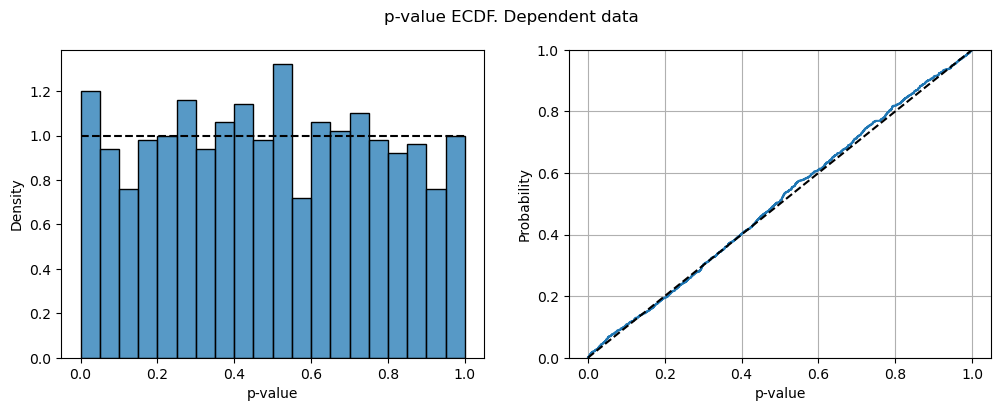

In [44]:
p_values=[]
grouped_sales=sales_hist.groupby('user_id')['price'].mean().reset_index()
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b=grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

Test power 

In [45]:
mean =grouped_sales['price'].mean()
std= grouped_sales['price'].std()
sample_size=grouped_sales.shape[0] // 2
alpha0= 0.05
beta0= 0.2
mde = get_minimal_determinable_effect(std, sample_size, alpha=alpha0, beta=beta0)
print(f'mde = {np.round(mde, 3)}')

mde = 15.866


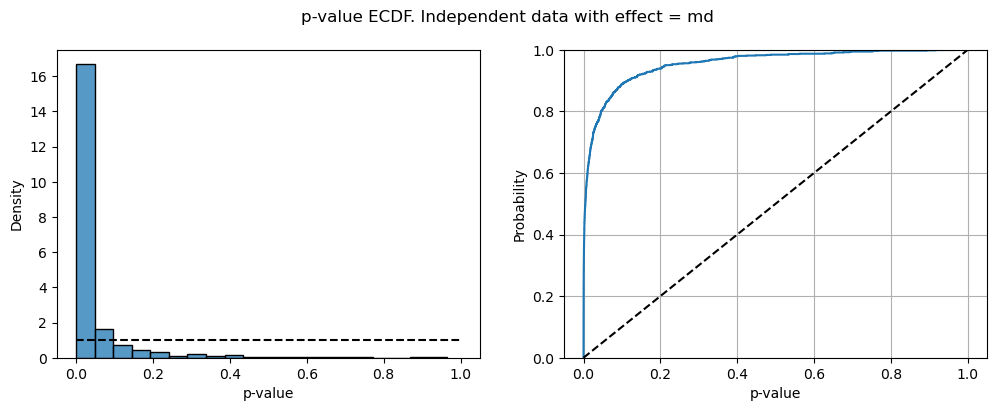

In [46]:
#Test power
p_values=[]
grouped_sales=sales_hist.groupby('user_id')['price'].mean().reset_index()
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b=grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b +=np.random.normal(mde,std // 10,sales_b.shape)   # adding a synthetic effect to historical data + a bit of variance
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = md')

The power of the test on 80% probability to detect a MDE.

In [47]:
def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

def estimate_errors(group_generator, effect_add_type, effect, alpha):
    pvalues_aa = []
    pvalues_ab = []
    for a_metric_values, b_metric_values in group_generator:
        pvalues_aa.append(get_ttest_pvalue(a_metric_values, b_metric_values))
        b_metric_values_with_effect = b_metric_values.copy()
        if effect_add_type == 'all_percent':
            b_metric_values_with_effect *= 1 + effect / 100
        elif effect_add_type == 'all_const':
            b_metric_values_with_effect += b_metric_values_with_effect.mean() * effect / 100
        pvalues_ab.append(get_ttest_pvalue(a_metric_values, b_metric_values_with_effect))
    first_type_error = np.mean(np.array(pvalues_aa) < alpha)
    second_type_error = np.mean(np.array(pvalues_ab) >= alpha)
    return pvalues_aa, pvalues_ab, first_type_error, second_type_error

## Bootstrap & confidence intervals

### 3 ways to build confidence intervals

In [48]:
def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):

    """ Builds a normal confidence interval.

    boot_metrics - metric values obtained with bootstrap
    pe_metric - point estimate of the metric
    alpha - significance level.
    
    return: (left, right) - boundaries of the confidence interval.
    """

    c = stats.norm.ppf(1 - alpha / 2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right


def get_ci_bootstrap_percentile(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Constructs a confidence interval at percentiles.

    boot_metrics - metric values obtained with bootstrap
    pe_metric - point estimate of the metric
    alpha - significance level
    
    return: (left, right) - boundaries of the confidence interval.
    """
    left, right = np.quantile(boot_metrics, [alpha / 2, 1 - alpha / 2])
    return left, right


def get_ci_bootstrap_pivotal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Constructs the central confidence interval.

    boot_metrics - metric values obtained with bootstrap
 pe_metric - point estimate of the metric
 alpha - significance level
    
    return: (left, right) - boundaries of the confidence interval.
    """
    right, left = 2 * pe_metric - np.quantile(boot_metrics, [alpha / 2, 1 - alpha / 2])
    return left, right

In [49]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

web_logs=read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date']=pd.to_datetime(web_logs['date'])
web_logs.head(5)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [50]:
np.random.seed(23)
web_logs_hist=web_logs
users=web_logs_hist['user_id'].unique()

np.random.shuffle(users)
group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
load_time_a=web_logs_hist[web_logs_hist['user_id'].isin(group_a)]['load_time'].values
load_time_b=web_logs_hist[web_logs_hist['user_id'].isin(group_b)]['load_time'].values

Our goal will be to construct a $95\%$ confidence interval for the $99.9%$ percentile difference.
$$H_0: P_{B; 99.9} = P_{A; 99.9}$$
$$H_1: P_{B; 99.9} \neq P_{A; 99.9}$$
First, let's implement a function with which we can get a point estimate

In [51]:
def get_point_estimate(a_group,b_group,quantile=0.999):
    return np.quantile(b_group,quantile) - np.quantile(a_group,quantile)

Let's run the usual bootstrap procedure, but taking into account that we have two samples. To do this, we will independently sample subsamples of the same size from the groups and calculate the bootstrap estimate. Let's repeat this procedure 1000 times.

In [52]:
point_estimate=get_point_estimate(load_time_a, load_time_b)
print(point_estimate)

-108.90149999987307


In [53]:
bs_point_estimates = []
for _ in range(1000):
    bs_a=np.random.choice(load_time_a,size=len(load_time_a),replace=True)
    bs_b=np.random.choice(load_time_b,size=len(load_time_b),replace=True)
    bs_point_estimate=get_point_estimate(bs_a, bs_b)
    bs_point_estimates.append(bs_point_estimate)

In [54]:
normal_ci=get_ci_bootstrap_normal(bs_point_estimates,point_estimate)
percentile_ci=get_ci_bootstrap_percentile(bs_point_estimates,point_estimate)
pivoval_ci=get_ci_bootstrap_pivotal(bs_point_estimates,point_estimate)

print(normal_ci,percentile_ci,pivoval_ci )

(-280.7299931076849, 62.926993107938785) (-282.4124074999948, 47.75602000067741) (-265.5590200004235, 64.60940750024866)


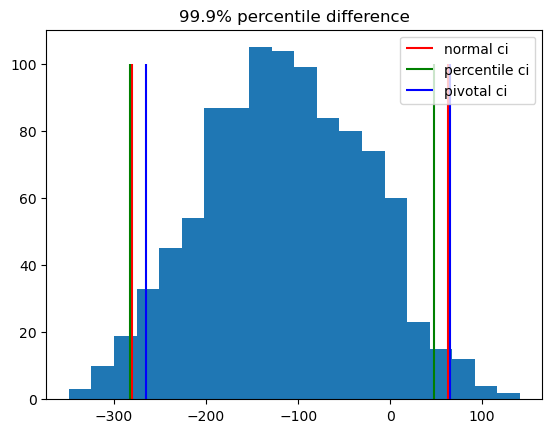

In [55]:
plt.title('99.9% percentile difference')
plt.hist(bs_point_estimates,bins=20)
plt.vlines(normal_ci,0,100,label='normal ci', color='red')
plt.vlines(percentile_ci,0,100,label='percentile ci', color='green')
plt.vlines(pivoval_ci,0,100,label='pivotal ci', color='blue')
plt.legend()
plt.show()


**Conclusion**: zero is inside the confidence interval, which means we cannot reject the null hypothesis that the 99.9 percentile is statistically significantly different.

### Experiment 
The experiment was conducted from 2022-04-05 to 2022-04-12. The measurements of request processing time are considered independent.

In [56]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-13/' 

web_logs=read_database('2022-04-13T12_df_web_logs.csv')
web_logs['date']=pd.to_datetime(web_logs['date'])
web_logs.head(5)


,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [57]:
df_users=read_database('experiment_users.csv')
df_users.head()

,user_id,pilot
0,c36b2e,0
1,20336e,0
2,034652,0
3,e98e3b,0
4,3f1105,0


In [58]:
begin_date=datetime(2022,4,5)
end_date=datetime(2022,4,12)
df_metrics=(
    web_logs[
        (web_logs['date']>=begin_date) &
        (web_logs['date']< end_date)
    ][['user_id','load_time']]
)
df= pd.merge(df_users,df_metrics, how='left',on='user_id')
df.describe()

,pilot,load_time
count,38936.000000,38936.000000
mean,0.505085,75.762854
std,0.499981,116.208595
min,0.000000,0.000000
25%,0.000000,65.100000
50%,1.000000,71.900000
75%,1.000000,78.400000
max,1.000000,4176.600000


In [59]:
B=1000 # number of bootstrap iterations
alpha=0.05

values_a=df[df['pilot']==0]['load_time'].values
values_b=df[df['pilot']==1]['load_time'].values
quantiles=np.array([0.7, 0.74, 0.78, 0.82, 0.86, 0.9, 0.95, 0.99, 0.999, 0.9999])
for q in quantiles:
    pe=np.quantile(values_b,q)-np.quantile(values_a,q)
    bootstrap_values_a=np.random.choice(values_a,(B,len(values_a)),replace=True)
    bootstrap_metrics_a=np.quantile(bootstrap_values_a,q,axis=1)
    bootstrap_values_b=np.random.choice(values_b,(B, len(values_b)), replace=True)
    bootstrap_metrics_b=np.quantile(bootstrap_values_b,q,axis=1)
    bootstrap_stats=bootstrap_metrics_b-bootstrap_metrics_a
    left,right=get_ci_bootstrap_normal(bootstrap_stats,pe,alpha=alpha)
    print(f'q = {q}, ci = [{left:0.3f}, {right:0.3f}], is effect = {not(left < 0 < right)} ')



q = 0.7, ci = [0.723, 1.277], is effect = True 
q = 0.74, ci = [0.301, 0.899], is effect = True 
q = 0.78, ci = [-0.295, 0.295], is effect = False 
q = 0.82, ci = [-1.016, -0.384], is effect = True 
q = 0.86, ci = [-1.553, -0.847], is effect = True 
q = 0.9, ci = [-2.475, -1.725], is effect = True 
q = 0.95, ci = [-3.892, -3.018], is effect = True 
q = 0.99, ci = [-7.314, -5.286], is effect = True 
q = 0.999, ci = [-1932.239, 1153.969], is effect = False 
q = 0.9999, ci = [-401.864, 465.289], is effect = False 


In [60]:
def run_bootstrap(bootstrap_metrics, pe_metric, alpha, bootstrap_ci_type):
    if bootstrap_ci_type == 'normal':
        c = stats.norm.ppf(1 - alpha / 2) 
        se = np.std(bootstrap_metrics)
        left, right = pe_metric - c * se, pe_metric + c * se
    elif bootstrap_ci_type == 'percentile':
        left, right = np.quantile(bootstrap_metrics, [alpha / 2, 1 - alpha / 2])
    elif bootstrap_ci_type == 'pivotal':
        q = np.quantile(bootstrap_metrics, [alpha / 2, 1 - alpha / 2])
        right, left = 2 * pe_metric - q
    else:
        raise ValueError('False bootstrap_ci_type')
    pvalue = float(left < 0 < right)
    return (left, right,), pvalue

## Variance reduction

In [61]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [62]:
web_logs = read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date']=pd.to_datetime(web_logs['date'])
web_logs.head(5)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [63]:
web_logs.describe()

,load_time
count,1.964507e+06
mean,7.396452e+01
std,1.107026e+02
min,0.000000e+00
25%,6.180000e+01
50%,7.000000e+01
75%,7.810000e+01
max,4.197500e+03


In [64]:
web_logs_hist = web_logs[
    (web_logs['date'] >= datetime(2022, 3, 22))
    & (web_logs['date'] < datetime(2022, 3, 29))
]
web_logs_hist.shape

(247163, 4)

In [65]:
alpha = 0.05
beta = 0.2

mean = web_logs_hist['load_time'].mean()
std = web_logs_hist['load_time'].std()

eff = mean * 0.01
print(f"variance is {std ** 2}")

variance is 12447.803325889645


In [66]:
sample_size = get_sample_size_abs(eff, std, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 355889


<AxesSubplot:>

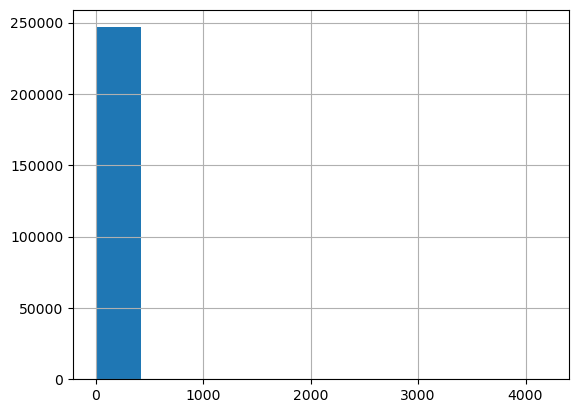

In [67]:
web_logs_hist['load_time'].hist()

<AxesSubplot:>

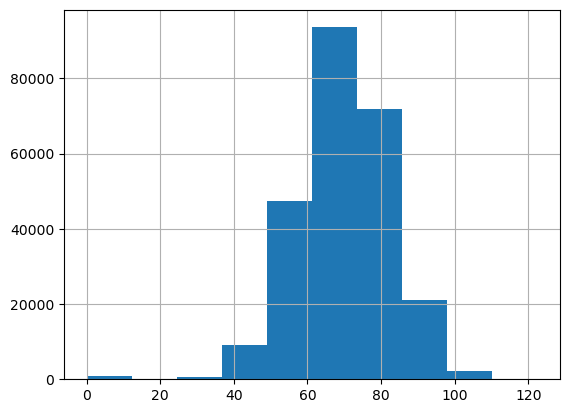

In [68]:
# without outliers
web_logs_filtered=web_logs_hist[web_logs_hist['load_time']<1000]
web_logs_filtered['load_time'].hist()


In [69]:
std = web_logs_filtered['load_time'].std()
print(f"var is {std ** 2}")

var is 162.09072353491075


In [70]:
sample_size=get_sample_size_abs(eff,std,alpha=alpha,beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 4635


The variance dropped by a factor of more than 76, causing the required sample size to drop by a factor of 76.

### Experiment  (Synthetic data)

Power of tests depending on the proportion of data to be deleted.

In [71]:

df_web_logs = read_database('2022-04-01T12_df_web_logs.csv')
df_web_logs['date'] = pd.to_datetime(df_web_logs['date'])

begin_date = datetime(2022, 3, 1)
end_date = datetime(2022, 3, 8)
df_metrics = (
    df_web_logs
    [(df_web_logs['date'] >= begin_date) & (df_web_logs['date'] < end_date)]
    [['user_id', 'load_time']]
)
users = df_metrics['user_id'].unique()

sample_size = 1000 # 1000 users
effect = 0.01 # 1% effect
alpha = 0.05
quantiles = (0.0001, 0.001, 0.01, 0.05, 0.1,)
quantile2errors = {q: [] for q in quantiles}

for _ in range(10000):
    a_users, b_users = np.random.choice(users, (2, sample_size,), False)
    a_values = df_metrics.loc[df_metrics['user_id'].isin(a_users), 'load_time'].values
    b_values = (
        df_metrics.loc[df_metrics['user_id'].isin(b_users), 'load_time'].values
        * (1 + effect) # adding a synthetic effect to historical data


    ) #Remove 2% of the outliers means removing 1% each of the minimum and maximum sample values. 
#That is, leave the values that lie between np.quantile(values, 0.01) and np.quantile(values, 0.99).
    for q in quantiles:
        a_values_filtered = a_values[
            (a_values > np.quantile(a_values, q))
            & (a_values < np.quantile(a_values, 1-q))
        ]
        b_values_filtered = b_values[
            (b_values > np.quantile(b_values, q))
            & (b_values < np.quantile(b_values, 1-q))
        ]
        pvalue = stats.ttest_ind(a_values_filtered, b_values_filtered).pvalue
        quantile2errors[q].append(pvalue > alpha)

def process_results(quantile2errors):
    """Process the data and output the result"""
    # list of elements: variant number, quantile, error rate, error list)
    data = [
        (idx+1, quantile, np.mean(errors), errors,)
        for idx, (quantile, errors) in enumerate(quantile2errors.items())
    ]
    # sort by error rate
    data.sort(key=lambda x: x[2])

     # check that the power estimates are meaningfully different from each other
    print(f'idx={data[0][0]} quantile={data[0][1]}, power={1-data[0][2]:0.3f}')
    for i in range(1, len(data)):
        pvalue = stats.ttest_ind(data[i][3], data[i-1][3]).pvalue
        if pvalue < 0.05:
            msg = f'pvalue={pvalue:0.4f}, the estimate of statistic power is significantly different from the previous'
        else:
            msg = f'pvalue={pvalue:0.4f}, the estimate of statistic power is not significantly different from the previous'
        print(f'idx={data[i][0]} quantile={data[i][1]}, power={1-data[i][2]:0.3f}, {msg}')
    print('answer:', ''.join([str(x[0]) for x in data]))

process_results(quantile2errors)

idx=5 quantile=0.1, power=0.970
idx=4 quantile=0.05, power=0.960, pvalue=0.0001, the estimate of statistic power is significantly different from the previous
idx=3 quantile=0.01, power=0.937, pvalue=0.0000, the estimate of statistic power is significantly different from the previous
idx=2 quantile=0.001, power=0.336, pvalue=0.0000, the estimate of statistic power is significantly different from the previous
idx=1 quantile=0.0001, power=0.089, pvalue=0.0000, the estimate of statistic power is significantly different from the previous
answer: 54321


In [72]:
def process_outliers(metrics, bounds, outlier_process_type):
    lower_bound, upper_bound = bounds
    metrics = metrics.copy()
    if outlier_process_type == 'drop':
        metrics = metrics[(metrics['metric'] >= lower_bound) & (metrics['metric'] <= upper_bound)]
    elif outlier_process_type == 'clip':
        metrics.loc[metrics['metric'] < lower_bound, 'metric'] = lower_bound
        metrics.loc[metrics['metric'] > upper_bound, 'metric'] = upper_bound
    else:
        raise ValueError('Invalid value of outlier_process_type')
    return metrics

### KPI choise 

In [75]:
df = pd.DataFrame({
    'revenue': [1500, 1800, 2100],
    'cost_price': [1300, 1200, 1600],
    'support': [1, 0, 0],
})
support_cost = 110

# metric = pd.Series([90, 600, 500])
def get_metric(df, support_cost):
    profit = df['revenue'] - df['cost_price'] - (df['support'] * support_cost)
    return profit

metric = get_metric(df, support_cost)
print(metric)

0     90
1    600
2    500
dtype: int64


In [76]:
sample_size = 1000
df_control = pd.DataFrame({
    'revenue': [int(np.sin(x / 12) * 600 + 1200) for x in range(sample_size)],
    'cost_price': [int(np.sin(x / 12) * 400 + 700) for x in range(sample_size)],
    'support': (np.arange(sample_size) < sample_size - 400).astype(int),
})
df_pilot = pd.DataFrame({
    'revenue': [int(np.sin(x / 11 + 1) * 650 + 1250) for x in range(sample_size)],
    'cost_price': [int(np.sin(x / 11 + 1) * 400 + 700) for x in range(sample_size)],
    'support': (np.arange(sample_size) < sample_size - 300).astype(int),
})
def get_metric(df, support_cost):
    return df['revenue'] - df['cost_price'] - support_cost * df['support']

for support_cost in range(316, 319):
    control_metric = get_metric(df_control, support_cost)
    pilot_metric = get_metric(df_pilot, support_cost)
    delta = pilot_metric.mean() - control_metric.mean()
    pvalue = ttest_ind(control_metric, pilot_metric).pvalue
    print(f'support_cost={support_cost} delta={delta:0.1f}, pvalue={pvalue:0.4f}')

support_cost=316 delta=19.5, pvalue=0.0484
support_cost=317 delta=19.4, pvalue=0.0499
support_cost=318 delta=19.3, pvalue=0.0515


### Stratification

In [87]:
from tqdm.notebook import tqdm

In [89]:
def calculate_mean(df):
    """Calculates the normal average of the ‘metric’ column."""
    return df['metric'].mean()


def calculate_stratified_mean(df, weights):
    """Calculates the stratified average.

    df - dataframe with target metric and data for stratification
    weights - dictionary - {stratum name: stratum weight}

    return: float, mean_strat
    """
    strat_mean = df.groupby('strat')['metric'].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # ! if there were no strats in the df data, then some of the weights will be erased and the sum of weights will be less than 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights['metric']).sum()
    return mean_strat


def check_test(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних для обычного среднего.
    
    return - pvalue.
    """
    values_control = df_control['metric'].values
    values_pilot = df_pilot['metric'].values
    _, pvalue = stats.ttest_ind(values_control, values_pilot)
    return pvalue

def calculate_strat_var(df, weights):
    """Calculates the stratified variance."""
    strat_vars = df.groupby('strat')['metric'].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # ! if there were no strats in the df data, then some of the weights will be erased and the sum of weights will be less than 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights['metric']).sum()
    return var_strat

def check_stratified_test(df_control, df_pilot, weights):
    """Checks the hypothesis of equality of means for the stratified mean.

    return - pvalue.
    """
    mean_strat_control = calculate_stratified_mean(df_control, weights)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights)
    var_strat_control = calculate_strat_var(df_control, weights)
    var_strat_pilot = calculate_strat_var(df_pilot, weights)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue


In [79]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01/2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_user_strats = read_database('user_strats.csv')

In [80]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [81]:
df_user_strats.head()

,user_id,strat
0,000096,1
1,0000d4,1
2,0000de,1
3,0000e4,1
4,0000e7,1


In [84]:
df_user_strats['strat'].value_counts()

1    58285
3    53518
2    11644
Name: strat, dtype: int64

In [85]:
begin_date = datetime(2022, 3, 23)
end_date = datetime(2022, 3, 30)
df_metrics=(
    df_sales[(df_sales['date']>=begin_date) & (df_sales['date']<=end_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price':'metric'})
    .reset_index()
)
df_metrics=pd.merge(df_metrics, df_user_strats, how='left', on='user_id')
df_metrics.head()

,user_id,metric,strat
0,0000d4,720,1
1,0000de,660,1
2,0000e4,840,1
3,0001e2,2430,1
4,0001ff,720,1


In [86]:
df_metrics.groupby('strat')['metric'].mean()

strat
1    1221.697525
2    1251.554174
3    1227.406882
Name: metric, dtype: float64

  0%|          | 0/1000 [00:00<?, ?it/s]

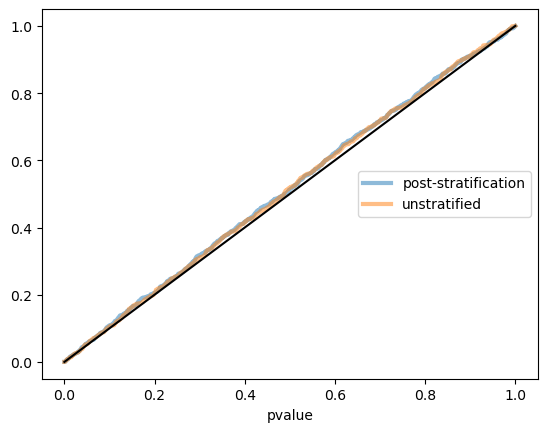

In [90]:
# Poststratification 
sample_size = 1000
weights = df_user_strats['strat'].value_counts(normalize=True).to_dict()
effect = 0

pvalues_random =[]
pvalues_poststratified =[]

for _ in tqdm (range(1000)):
    control_users, pilot_users = np.random.choice(df_metrics['user_id'].values, (2, sample_size,), False)
    df_control = df_metrics[df_metrics['user_id'].isin(control_users)].copy()
    df_pilot = df_metrics[df_metrics['user_id'].isin(pilot_users)].copy()
    df_pilot['metric'] += effect
    pvalues_random.append(check_test(df_control, df_pilot))
    pvalues_poststratified.append(check_stratified_test(df_control, df_pilot, weights))


list_pvalues = [pvalues_random, pvalues_poststratified]
list_titles = ['unstratified', 'post-stratification']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()
